In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pandas.io.json import json_normalize
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# 데이터 전처리

In [ ]:
def lolDataEda(csv_name):
    global lol_df
    lol_df = pd.read_csv(f'./{csv_name}.csv', encoding='CP949')

    # 승패 변환
    wl_mapping = {True: 1, False: 0}
    lol_df['blueWins'] = lol_df['blueWins'].map(wl_mapping)
    lol_df['redWins'] = lol_df['redWins'].map(wl_mapping)

    # dragon_type 변환
    dragontype = ['WATER_DRAGON', 'FIRE_DRAGON', 'AIR_DRAGON', 'EARTH_DRAGON', 'CHEMTECH_DRAGON', 'HEXTECH_DRAGON']
    n_dragontype = 6

    for i in dragontype:  # 리스트형태 없애기
        lol_df = lol_df.replace(f"['{i}']", i)

    bDT = lol_df['blueDragonType'].tolist()  # ','를 기준으로 데이터값 구분하기(리스트로 변환)
    rDT = lol_df['redDragonType'].tolist()
    for i in range(len(bDT)):
        try:
            bDT[i] = bDT[i].split(',')
        except:
            bDT[i] = 'NO_DRAGON'
    for i in range(len(rDT)):
        try:
            rDT[i] = rDT[i].split(',')
        except:
            rDT[i] = 'NO_DRAGON'

    one_hot_mat = list()  # 리스트 원핫인코딩 후 다시 데이터프레임에 집어넣기(blue)
    for _ in range(len(bDT)):
        one_hot_vec = list()
        for _ in range(n_dragontype):
            one_hot_vec.append(0)
        one_hot_mat.append(one_hot_vec)

    for bDT_idx, bDTs in enumerate(bDT):
        one_hot_vec = one_hot_mat[bDT_idx]
        for i in bDTs:
            if i == 'WATER_DRAGON':
                one_hot_vec[0] = 1
            elif i == 'FIRE_DRAGON':
                one_hot_vec[1] = 1
            elif i == 'AIR_DRAGON':
                one_hot_vec[2] = 1
            elif i == 'EARTH_DRAGON':
                one_hot_vec[3] = 1
            elif i == 'CHEMTECH_DRAGON':
                one_hot_vec[4] = 1
            elif i == 'HEXTECH_DRAGON':
                one_hot_vec[5] = 1
    dragon_df = np.array(one_hot_mat)
    dragon_df = pd.DataFrame(dragon_df, columns=[f'blue{i}' for i in dragontype])
    lol_df = pd.concat([lol_df, dragon_df], axis=1)

    one_hot_mat = list()  # (red)
    for _ in range(len(bDT)):
        one_hot_vec = list()
        for _ in range(n_dragontype):
            one_hot_vec.append(0)
        one_hot_mat.append(one_hot_vec)

    for rDT_idx, rDTs in enumerate(rDT):
        one_hot_vec = one_hot_mat[rDT_idx]
        for i in rDTs:
            if i == 'WATER_DRAGON':
                one_hot_vec[0] = 1
            elif i == 'FIRE_DRAGON':
                one_hot_vec[1] = 1
            elif i == 'AIR_DRAGON':
                one_hot_vec[2] = 1
            elif i == 'EARTH_DRAGON':
                one_hot_vec[3] = 1
            elif i == 'CHEMTECH_DRAGON':
                one_hot_vec[4] = 1
            elif i == 'HEXTECH_DRAGON':
                one_hot_vec[5] = 1
    dragon_df = np.array(one_hot_mat)
    dragon_df = pd.DataFrame(dragon_df, columns=[f'red{i}' for i in dragontype])
    lol_df = pd.concat([lol_df, dragon_df], axis=1)

    lol_df = lol_df.drop(
        columns=['gameId', 'Unnamed: 0', 'blueCurrentGolds', 'blueAvgLevel', 'blueFirstTowerLane', 'blueDragonType',
                 'redWins', 'redCurrentGolds', 'redAvgLevel', 'redFirstTowerLane', 'redDragonType', 'redKill', 'redDeath'])
    
    return lol_df.head()

In [ ]:
lolDataEda("GM15")

,blueWins,blueTotalGolds,blueTotalLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueTotalDamageToChampion,blueFirstBlood,blueKill,blueDeath,blueAssist,...,blueAIR_DRAGON,blueEARTH_DRAGON,blueCHEMTECH_DRAGON,blueHEXTECH_DRAGON,redWATER_DRAGON,redFIRE_DRAGON,redAIR_DRAGON,redEARTH_DRAGON,redCHEMTECH_DRAGON,redHEXTECH_DRAGON
0,0,21357,36,354,68,11028,0,6,9,8,...,0,0,1,0,0,0,0,1,0,0
1,1,24686,39,330,75,28032,1,17,7,21,...,0,0,0,1,0,0,0,0,0,0
2,1,22433,37,323,64,25973,0,15,11,16,...,0,1,0,0,0,0,0,0,0,0
3,0,20010,36,308,55,18835,0,10,13,10,...,0,0,1,0,0,1,0,0,0,0
4,1,23844,38,338,80,22447,1,13,12,21,...,1,0,0,0,0,0,0,0,0,0


# 데이터EDA

In [ ]:
lol_df.select_dtypes(['int64','float64']).corr()[['blueWins']]

,blueWins
blueWins,1.000000
blueTotalGolds,0.415878
blueTotalLevel,0.238933
blueTotalMinionKills,0.169748
blueTotalJungleMinionKills,0.083465
blueTotalDamageToChampion,0.250728
blueFirstBlood,0.188851
blueKill,0.337567
blueDeath,-0.317952
blueAssist,0.269195


In [ ]:
def first_valid_visualize(df,target,variable):

    sns.catplot(x=target, y=variable, kind='point', data=df)
    plt.title(variable+'WinRate')
    #plt.xticks(df[target])
    return plt.show()

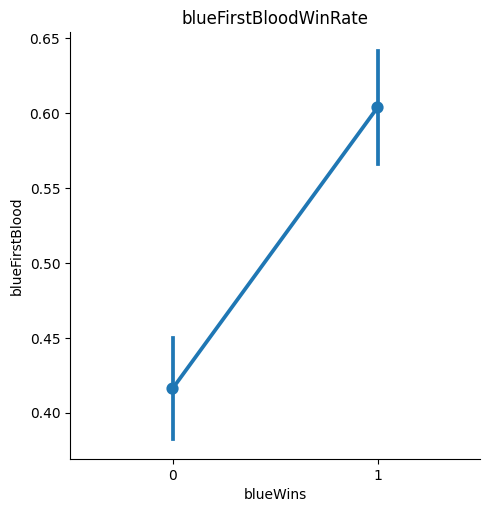

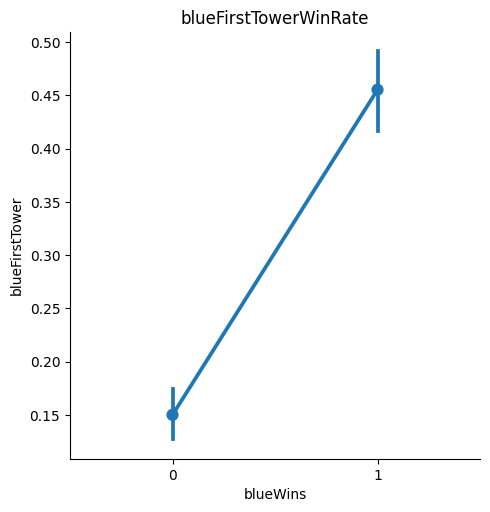

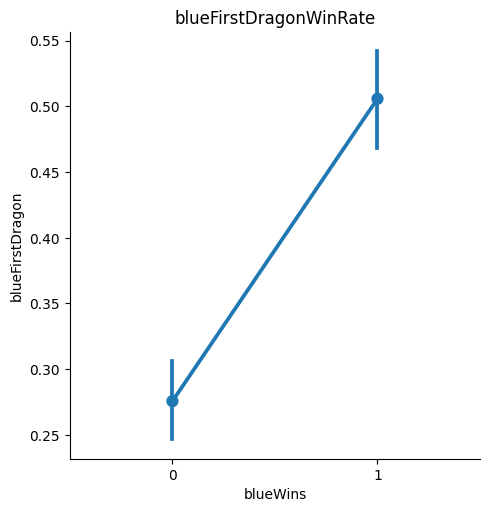

In [ ]:
first_valid_visualize(lol_df,'blueWins','blueFirstBlood')
first_valid_visualize(lol_df,'blueWins','blueFirstTower')
first_valid_visualize(lol_df,'blueWins','blueFirstDragon')

# Logistic Regression

In [ ]:
reg_df = lol_df

feature_columns = list(reg_df.columns.difference(["blueWins"]))
x_data = reg_df[feature_columns]
y_data = reg_df['blueWins']
x_data.head()

,blueAIR_DRAGON,blueAssist,blueBotTowerKills,blueCHEMTECH_DRAGON,blueDeath,blueDragon,blueEARTH_DRAGON,blueFIRE_DRAGON,blueFirstBlood,blueFirstDragon,...,redTopTowerKills,redTotalDamageToChampion,redTotalGolds,redTotalJungleMinionKills,redTotalLevel,redTotalMinionKills,redTowerKills,redWATER_DRAGON,redWardKills,redWardPlaced
0,0,8,1,1,9,1,0,0,0,1,...,0,22471,28979,71,52,414,0,0,14,30
1,0,21,0,0,7,1,0,0,1,1,...,0,31291,29367,70,50,367,2,0,7,35
2,0,16,0,0,11,2,1,1,0,1,...,0,30895,33145,76,51,345,2,0,7,22
3,0,10,0,1,13,1,0,0,0,1,...,0,30173,30438,83,51,338,1,0,8,38
4,1,21,0,0,12,2,0,0,1,1,...,0,28037,30591,72,52,389,1,0,9,41


,blueAIR_DRAGON,blueAssist,blueBotTowerKills,blueCHEMTECH_DRAGON,blueDeath,blueDragon,blueEARTH_DRAGON,blueFIRE_DRAGON,blueFirstBlood,blueFirstDragon,...,redTopTowerKills,redTotalDamageToChampion,redTotalGolds,redTotalJungleMinionKills,redTotalLevel,redTotalMinionKills,redTowerKills,redWATER_DRAGON,redWardKills,redWardPlaced
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,...,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,0.101249,0.326304,0.094675,0.106509,0.361400,0.289941,0.101249,0.093360,0.501644,0.380671,...,0.070787,0.451692,0.406086,0.319782,0.607546,0.436205,0.069625,0.147272,0.228656,0.054466
std,0.301758,0.167836,0.204982,0.308589,0.153748,0.339927,0.301758,0.291031,0.500162,0.485711,...,0.147694,0.149758,0.157726,0.094655,0.139504,0.123158,0.087647,0.354493,0.095246,0.065509
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.205128,0.000000,0.000000,0.241379,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.348680,0.291147,0.256198,0.538462,0.357143,0.000000,0.000000,0.166667,0.030075
50%,0.000000,0.307692,0.000000,0.000000,0.344828,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.441237,0.389970,0.314050,0.615385,0.435714,0.100000,0.000000,0.214286,0.040100
75%,0.000000,0.435897,0.000000,0.000000,0.448276,0.500000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.545304,0.500976,0.371901,0.692308,0.514286,0.100000,0.000000,0.261905,0.052632
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
vif["features"] = x_data.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.059648,redWardPlaced
1,1.076898,blueWardPlaced
2,1.157287,redWardKills
3,1.169339,blueWardKills
4,1.436057,redTotalJungleMinionKills
5,1.592877,blueTotalJungleMinionKills
6,2.349681,redTotalMinionKills
7,2.406902,redTotalLevel
8,2.622038,blueTotalDamageToChampion
9,2.936074,redTotalDamageToChampion


In [ ]:
# 단계 선택법

variables = x_data.columns.tolist() ## 설명 변수 리스트
 
y = y_data ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder, dtype=float) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x_data[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = x_data[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(x_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [ ]:
selected_variables

['blueTotalGolds',
 'blueDeath',
 'redDragon',
 'redTotalGolds',
 'blueKill',
 'blueDragon',
 'blueBotTowerKills',
 'redTowerKills',
 'redFirstTower',
 'blueMidTowerKills',
 'blueAIR_DRAGON',
 'blueFirstDragon',
 'redTotalMinionKills',
 'redAssist']

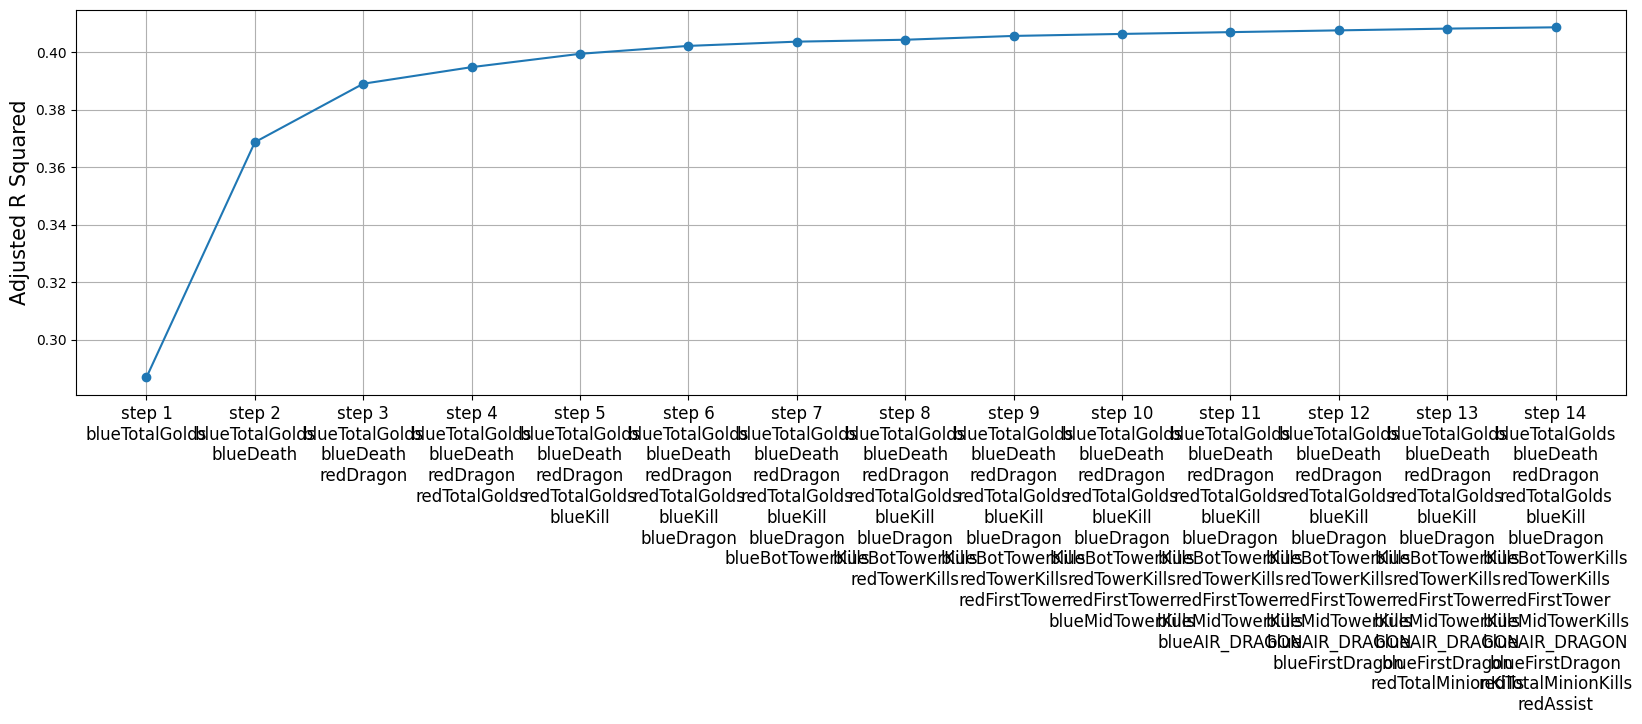

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [ ]:
x_data_selected = x_data[selected_variables]
x_data_selected.head()

,blueTotalGolds,blueDeath,redDragon,redTotalGolds,blueKill,blueDragon,blueBotTowerKills,redTowerKills,redFirstTower,blueMidTowerKills,blueAIR_DRAGON,blueFirstDragon,redTotalMinionKills,redAssist
0,21357,9,1,28979,6,1,1,0,0,0,0,1,414,9
1,24686,7,0,29367,17,1,0,2,1,0,0,1,367,7
2,22433,11,0,33145,15,2,0,2,1,0,0,1,345,13
3,20010,13,1,30438,10,1,0,1,1,0,0,1,338,15
4,23844,12,0,30591,13,2,0,1,1,0,1,1,389,19


In [ ]:
# min-max 정규화
scaler = StandardScaler()
scaler.fit(x_data)
x_data = scaler.transform(x_data)

x_data = pd.DataFrame(x_data, columns=reg_df[feature_columns].columns.tolist())
x_data.describe()

,blueAIR_DRAGON,blueAssist,blueBotTowerKills,blueCHEMTECH_DRAGON,blueDeath,blueDragon,blueEARTH_DRAGON,blueFIRE_DRAGON,blueFirstBlood,blueFirstDragon,...,redTopTowerKills,redTotalDamageToChampion,redTotalGolds,redTotalJungleMinionKills,redTotalLevel,redTotalMinionKills,redTowerKills,redWATER_DRAGON,redWardKills,redWardPlaced
count,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,...,1.521000e+03,1.521000e+03,1.521000e+03,1521.000000,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,1.521000e+03,1521.000000
mean,1.167887e-17,-7.007325e-18,1.751831e-17,-2.102197e-17,-4.671550e-18,2.802930e-17,-6.656959e-17,5.839437e-19,2.452564e-17,4.788339e-17,...,5.372282e-17,-9.343100e-18,9.343100e-18,0.000000,-1.751831e-18,-3.503662e-18,2.686141e-17,-9.343100e-18,5.839437e-19,0.000000
std,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,...,1.000329e+00,1.000329e+00,1.000329e+00,1.000329,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,1.000329e+00,1.000329
min,-3.356418e-01,-1.944815e+00,-4.620193e-01,-3.452612e-01,-2.351367e+00,-8.532319e-01,-3.356418e-01,-3.208943e-01,-1.003293e+00,-7.839960e-01,...,-4.794386e-01,-3.017143e+00,-2.575475e+00,-3.379522,-4.356487e+00,-3.542997e+00,-7.946421e-01,-4.155794e-01,-2.401483e+00,-0.831696
25%,-3.356418e-01,-7.222219e-01,-4.620193e-01,-3.452612e-01,-7.808881e-01,-8.532319e-01,-3.356418e-01,-3.208943e-01,-1.003293e+00,-7.839960e-01,...,-4.794386e-01,-6.880806e-01,-7.289657e-01,-0.671965,-4.953768e-01,-6.421683e-01,-7.946421e-01,-4.155794e-01,-6.510489e-01,-0.372444
50%,-3.356418e-01,-1.109256e-01,-4.620193e-01,-3.452612e-01,-1.078257e-01,-8.532319e-01,-3.356418e-01,-3.208943e-01,9.967181e-01,-7.839960e-01,...,-4.794386e-01,-6.983569e-02,-1.022102e-01,-0.060581,5.621040e-02,-3.986017e-03,3.466710e-01,-4.155794e-01,-1.509250e-01,-0.219360
75%,-3.356418e-01,6.531949e-01,-4.620193e-01,-3.452612e-01,5.652367e-01,6.181578e-01,-3.356418e-01,-3.208943e-01,9.967181e-01,1.275517e+00,...,-4.794386e-01,6.252940e-01,6.018115e-01,0.550802,6.077976e-01,6.341963e-01,3.466710e-01,-4.155794e-01,3.491990e-01,-0.028005
max,2.979366e+00,4.015325e+00,4.418059e+00,2.896358e+00,4.154903e+00,2.089548e+00,2.979366e+00,3.116291e+00,9.967181e-01,1.275517e+00,...,6.293559e+00,3.662506e+00,3.766721e+00,7.188685,2.814146e+00,4.579323e+00,1.061849e+01,2.406279e+00,8.101120e+00,14.438426


In [ ]:
# 테스트 데이터 나누기
x_data = sm.add_constant(x_data, has_constant='add')    # 상수항 추가
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, stratify=y_data,train_size=0.7,test_size=0.3,random_state=42)
test_x

,const,blueAIR_DRAGON,blueAssist,blueBotTowerKills,blueCHEMTECH_DRAGON,blueDeath,blueDragon,blueEARTH_DRAGON,blueFIRE_DRAGON,blueFirstBlood,...,redTopTowerKills,redTotalDamageToChampion,redTotalGolds,redTotalJungleMinionKills,redTotalLevel,redTotalMinionKills,redTowerKills,redWATER_DRAGON,redWardKills,redWardPlaced
499,1.0,-0.335642,0.500371,-0.462019,-0.345261,0.116528,-0.853232,-0.335642,-0.320894,0.996718,...,-0.479439,0.672093,0.103333,-0.846646,0.056210,-0.149027,-0.794642,-0.415579,1.349447,-0.372444
887,1.0,-0.335642,-0.875046,-0.462019,-0.345261,-0.107826,-0.853232,-0.335642,-0.320894,-1.003293,...,-0.479439,-0.632132,-0.049699,0.550802,0.056210,-0.613160,0.346671,-0.415579,-0.901111,-0.257631
93,1.0,-0.335642,3.404029,1.978020,-0.345261,-1.229596,0.618158,-0.335642,3.116291,-1.003293,...,-0.479439,0.778888,-1.648657,-0.584625,-1.598551,-1.222334,-0.794642,-0.415579,-0.400987,-0.448986
1478,1.0,-0.335642,0.041899,-0.462019,-0.345261,-1.229596,2.089548,2.979366,-0.320894,0.996718,...,-0.479439,-0.062446,-1.110045,0.201440,-0.495377,0.402130,-0.794642,-0.415579,-0.150925,-0.525528
1494,1.0,-0.335642,-0.875046,-0.462019,-0.345261,0.340883,0.618158,-0.335642,3.116291,-1.003293,...,-0.479439,0.625294,-0.185853,0.550802,1.710972,0.634196,-0.794642,-0.415579,0.099137,0.813957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,1.0,-0.335642,0.041899,1.978020,-0.345261,-0.780888,-0.853232,-0.335642,-0.320894,-1.003293,...,-0.479439,-0.981721,-1.096917,0.812824,-1.046964,-0.178036,-0.794642,-0.415579,0.099137,-0.066276
1308,1.0,-0.335642,0.500371,-0.462019,-0.345261,-1.005242,-0.853232,-0.335642,-0.320894,0.996718,...,-0.479439,0.117890,-0.335134,0.550802,-0.495377,-0.149027,-0.794642,-0.415579,0.349199,-0.448986
626,1.0,-0.335642,-0.722222,4.418059,-0.345261,-1.902659,0.618158,-0.335642,3.116291,0.996718,...,-0.479439,-2.486164,-1.559764,0.550802,0.607798,1.011304,-0.794642,-0.415579,-0.400987,-0.334173
1014,1.0,-0.335642,0.041899,-0.462019,-0.345261,1.687007,-0.853232,-0.335642,-0.320894,0.996718,...,1.778227,0.871079,1.983975,1.686230,1.159385,0.083039,3.770610,-0.415579,-1.401235,-0.372444


In [ ]:
# LR 모델링
log_model = sm.Logit(train_y, train_x)
results = log_model.fit(method='newton')

results.summary2()

         Current function value: 0.407990
         Iterations: 35


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                 Results: Logit
================================================================================================================
Model:                               Logit                           Pseudo R-squared:                0.408     
Dependent Variable:                  blueWins                        AIC:                             960.2027  
Date:                                2023-04-10 09:45                BIC:                             1188.8130 
No. Observations:                    1064                            Log-Likelihood:                  -434.10   
Df Model:                            45                              LL-Null:                         -733.35   
Df Residuals:                        1018                            LLR p-value:                     8.4615e-98
Converged:                           0.0000                          Scale:                           1.0000    
No. Iterations:                      35.0000                                                                    
----------------------------------------------------------------------------------------------------------------
                            Coef.        Std.Err.         z    P>|z|          [0.025               0.975]       
----------------------------------------------------------------------------------------------------------------
const                      -0.3307          36843.1762 -0.0000 1.0000           -72211.6293           72210.9678
blueAIR_DRAGON              0.0654                 nan     nan    nan                   nan                  nan
blueAssist                 -0.0786              0.1723 -0.4559 0.6485               -0.4163               0.2592
blueBotTowerKills           0.0576        3161439.3195  0.0000 1.0000         -6196307.1479         6196307.2630
blueCHEMTECH_DRAGON        -0.0576                 nan     nan    nan                   nan                  nan
blueDeath                  -0.1398              0.2890 -0.4836 0.6287               -0.7063               0.4267
blueDragon                  0.1664                 nan     nan    nan                   nan                  nan
blueEARTH_DRAGON            0.1756                 nan     nan    nan                   nan                  nan
blueFIRE_DRAGON             0.0482                 nan     nan    nan                   nan                  nan
blueFirstBlood             -0.0290       14282515.8569 -0.0000 1.0000        -27993216.7171        27993216.6592
blueFirstDragon            -0.1536              0.2776 -0.5534 0.5800               -0.6977               0.3904
blueFirstInhibitor          0.3949     6806305491.8019  0.0000 1.0000     -13340113631.3140     13340113632.1038
blueFirstTower              0.2045              0.1644  1.2442 0.2134               -0.1177               0.5268
blueHEXTECH_DRAGON         -0.0005                 nan     nan    nan                   nan                  nan
blueInhibitor               0.3949     7135619658.7047  0.0000 1.0000     -13985557538.0424     13985557538.8322
blueKill                    1.1451              0.3172  3.6096 0.0003                0.5233               1.7669
blueMidTowerKills          -0.0858        2861726.0707 -0.0000 1.0000         -5608880.1180         5608879.9465
blueRiftHeralds            -0.3668              0.4686 -0.7827 0.4338               -1.2852               0.5516
blueTopTowerKills          -0.1015        3088440.0435 -0.0000 1.0000         -6053231.3552         6053231.1522
blueTotalDamageToChampion  -0.0982              0.1460 -0.6727 0.5011               -0.3842               0.1879
blueTotalGolds              0.7262              0.3379  2.1492 0.0316                0.0639               1.3884
blueTotalJungleMinionKills  0.1511              0.1092  1.3838 0.1664               -0.0629               0.3651
blueTotalLevel              0.0292           

In [ ]:
pred_y = results.predict(test_x)

def cut_off(y,threshold):
    Y = y.copy() # copy함수를 사용하여 이전의 y값이 변화지 않게 함
    Y[Y>threshold]=1
    Y[Y<=threshold]=0
    return(Y.astype(int))

pred_Y = cut_off(pred_y,0.5)
cfmat = confusion_matrix(test_y,pred_Y)

# 정확도
(cfmat[0,0]+cfmat[1,1])/np.sum(cfmat) 

0.7833698030634574